# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [63]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [64]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score as aps
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore")

def auc_pr(x, y):
    pres, rec, _  = precision_recall_curve(x, y)
    return auc(pres, rec)

auc_pr = make_scorer(auc_pr)
ap_score = make_scorer(aps)

In [65]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=777)

In [66]:
best_score = 0
best_c = 0

for c in np.logspace(-5, 2, 10):
    model = LinearSVC(C=c, max_iter=10000)
    model.fit(X_train_t, y_train_t)
    pred = model.decision_function(X_val)
    score = aps(y_val, pred)
    if score > best_score:
        best_score = score
        best_c = c

In [67]:
print(f'Лучашя С: {best_c}')
print(f'Лучший скор: {best_score}')

Лучашя С: 100.0
Лучший скор: 0.8409493084911854


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [68]:
model = LinearSVC(max_iter=100000, C=best_c)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)
print(f'PR: {aps(y_test, pred):.5f}')
print(f'ROC: {roc_auc_score(y_test, pred):.5f}')

PR: 0.82994
ROC: 0.84760


In [69]:
pred_rand = np.random.randint(2, size=len(y_test))
print(f'PR: {aps(y_test, pred_rand):.5f}')
print(f'ROC: {roc_auc_score(y_test, pred_rand):.5f}')

PR: 0.50528
ROC: 0.49922


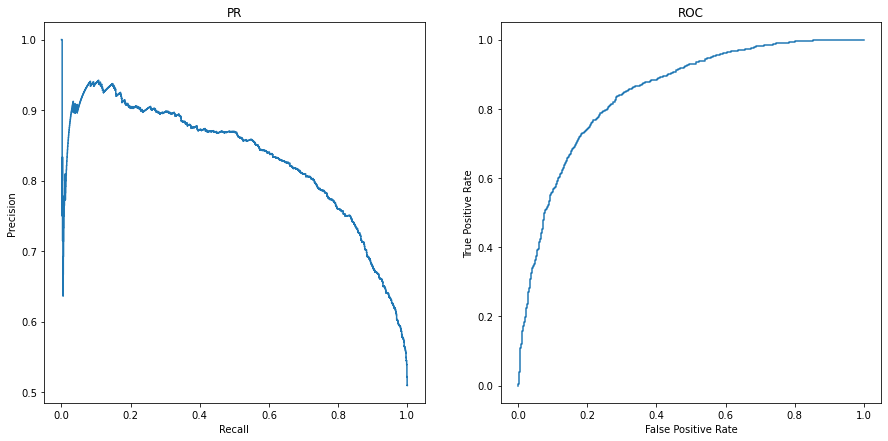

In [70]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

model =  LinearSVC(max_iter=100000, C=best_c)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

precision, recall, _ = precision_recall_curve(y_test, pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
ax1.set_title('PR')
disp.plot(ax1)

fpr, tpr, _ = roc_curve(y_test, pred) 
disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
ax2.set_title('ROC')
disp.plot(ax2)
plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [71]:
best_score = 0
best_c = 0

for c in np.logspace(-5, 2, 10):
    model = LR(C=c, max_iter=10000)
    model.fit(X_train_t, y_train_t)
    pred = model.decision_function(X_val)
    score = aps(y_val, pred)
    if score > best_score:
        best_score = score
        best_c = c

In [72]:
print(f'Лучашя С: {best_c}')
print(f'Лучший скор: {best_score}')

Лучашя С: 0.0021544346900318843
Лучший скор: 0.8267373022359118


In [73]:
model = LR(max_iter=100000, C=best_c)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)
print(f'PR: {aps(y_test, pred):.5f}')
print(f'ROC: {roc_auc_score(y_test, pred):.5f}')

PR: 0.83221
ROC: 0.84662


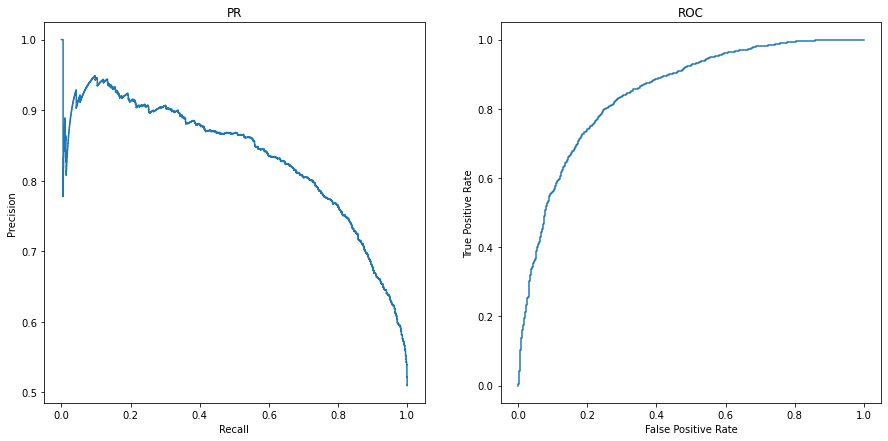

In [74]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

model = LR(max_iter=100000, C=best_c)
model.fit(X_train, y_train)
pred = model.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

precision, recall, _ = precision_recall_curve(y_test, pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
ax1.set_title('PR')
disp.plot(ax1)

fpr, tpr, _ = roc_curve(y_test, pred) 
disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
ax2.set_title('ROC')
disp.plot(ax2)
plt.show()

ROC лучше у LR примерно на 0.001, а PR лучше у SVC на 0.002, кажется, что это не столь существенные различия.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [75]:
X, y = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

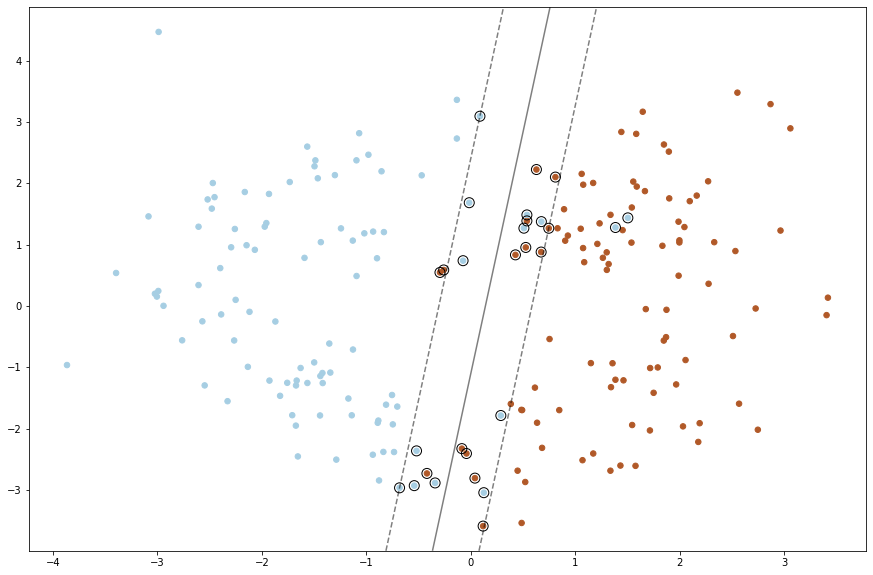

In [76]:
from sklearn import svm
from sklearn.datasets import make_blobs
# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py

# we create 40 separable points
X, y = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0, class_sep=1.5,
    random_state=42)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

fig, ax = plt.subplots(figsize=(15, 10))


ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
#ax = plt.gca(figsize=(10, 7))
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

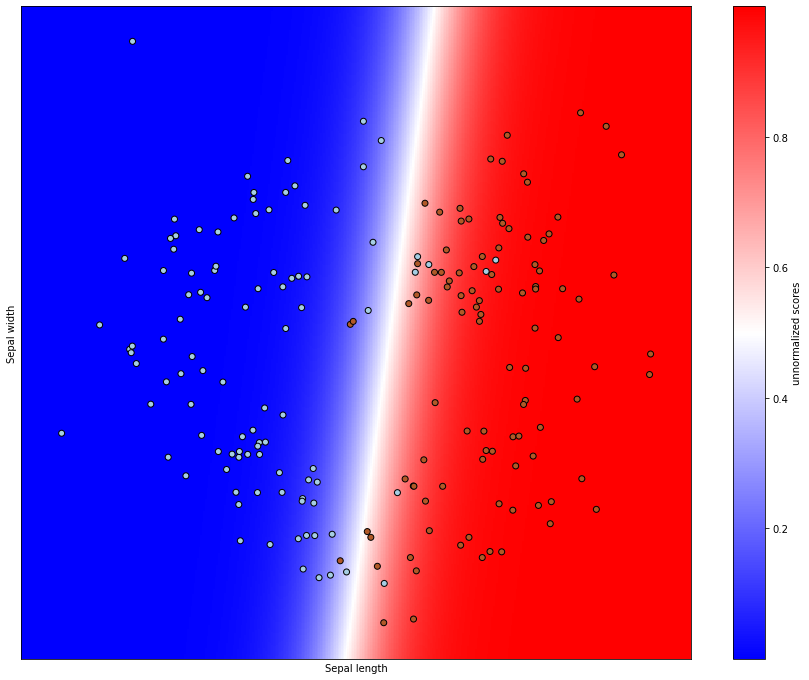

In [80]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
logreg = LR()
logreg.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15, 12))
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('bwr'))
plt.colorbar(label='unnormalized scores')


# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [81]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append(l + (r - l) / 2) # 1
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)])) # 2
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [82]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

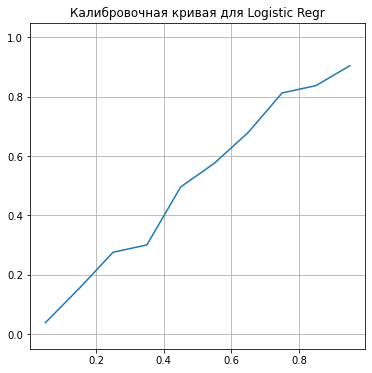

In [83]:
model = LR()
model.fit(X_train, y_train)

plot_calibration_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.title('Калибровочная кривая для Logistic Regr')
plt.show()

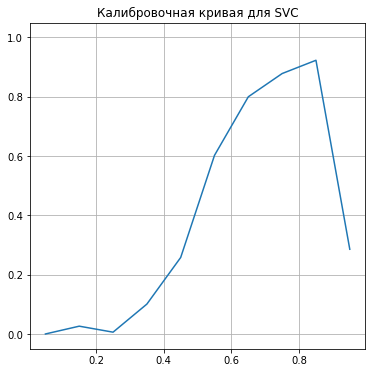

In [84]:
model = svm.SVC(kernel="linear")
model.fit(X_train, y_train)
pred = X_test @ model.coef_.T
pred = (pred - pred.min()) / (pred.max() - pred.min())

plot_calibration_curve(y_test, pred.reshape(-1))
plt.title('Калибровочная кривая для SVC')
plt.show()

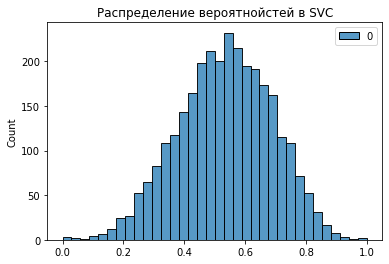

In [85]:
import seaborn as sns

sns.histplot(pred)
plt.title('Распределение вероятнойстей в SVC')
plt.show()

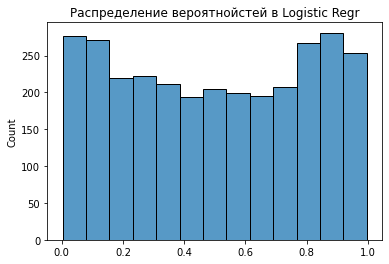

In [86]:
model = LR()
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]

sns.histplot(pred)
plt.title('Распределение вероятнойстей в Logistic Regr')
plt.show()

Логично, что вероятности в SVC имеют нормальное распределение, мы же подогнали их искусственно, в LR же это больше похоже на правду, что мы и видим на калибровочных кривых - LR сильно лучше оценивает вероятности.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

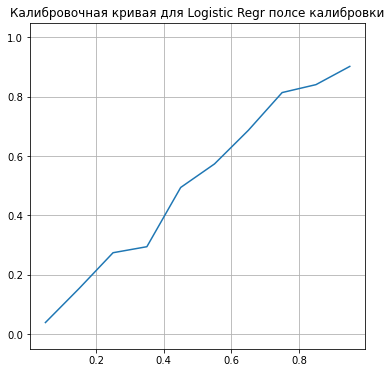

In [87]:
from sklearn.calibration import CalibratedClassifierCV

clf = CalibratedClassifierCV(LR(), cv=5)
clf.fit(X_train, y_train)
plot_calibration_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.title('Калибровочная кривая для Logistic Regr полсе калибровки')
plt.show()

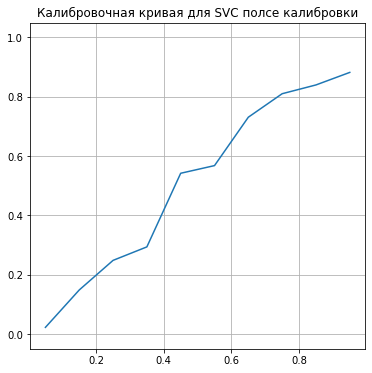

In [88]:
clf = CalibratedClassifierCV(svm.SVC(kernel="linear"), cv=5)
clf.fit(X_train, y_train)
plot_calibration_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.title('Калибровочная кривая для SVC полсе калибровки')
plt.show()

Да, стало сильно лучше

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [25]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [26]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [27]:
df = df.drop(columns=['duration'])

In [28]:
X = df.drop(columns=['y'])
y = df['y']
y = np.where(y == 'yes', 1, 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Кажется, что классы в таргете очень несбалансированны, что может поломать AUC-ROC, а AUC-PR как раз должна это учитывать.

In [31]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
other = []

In [30]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


In [760]:
%%time

column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4398538915285427
Test: 0.44115422530059345
Wall time: 2.18 s


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [761]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.44552558346646065
Test: 0.44448686531940884
Wall time: 1.65 s


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [33]:
from sklearn.base import BaseEstimator,TransformerMixin

In [762]:
def mean_targ(df, columns_to_trans, target):
    other = df.drop(columns = columns_to_trans)
    df = df[columns_to_trans]
    df['target'] = target
    for col in df.columns:
        if col == 'target':
            continue
        
        grouped = df.groupby(by=[col]).mean()
        new_feats = grouped['target']
        feats_to_conv = grouped.index
        df[col].replace(feats_to_conv, new_feats, inplace=True)
    return pd.concat([other, df.drop(columns=['target'])], axis=1)  
        

In [34]:
class Mean_targ_enc(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_trans):
        self.columns = columns_to_trans
        self.new_feats = []
        self.feats_to_conv = []
        
    def fit(self, df, target):
        
        df = df[self.columns]
        df['target'] = target
        
        for col in self.columns:  
            grouped = df.groupby(by=[col]).mean()
            self.new_feats.append(grouped['target'])
            self.feats_to_conv.append(grouped.index)

        return self
    
    def transform(self, df, target=None):
        df = df.copy()
        for i, col in enumerate(self.columns):
            new_feats = np.setdiff1d(np.unique(df[col]), self.feats_to_conv[i])
            df[col].replace(self.feats_to_conv[i], self.new_feats[i], inplace=True)
            if len(new_feats > 0):
                df[col].replace(self.feats_to_conv[i], self.new_feats[i], inplace=True)
        return df
            

In [35]:
%%time
coder = Mean_targ_enc(categorical)
X_train_trans = coder.fit_transform(X_train, y_train)
X_test_trans = coder.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.42090916435588477
Test: 0.4259330294162596
Wall time: 538 ms


За счёт того, что мы не создаём новых признаков время сильно уменьшилось, но и качество стало сильно ниже.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [36]:
class Mean_targ_enc_noise(Mean_targ_enc):
    def fit(self, df, target, shift=10):
        df = df.copy()
        df = df[self.columns]
        df['target'] = target
        
        for col in self.columns:
            
            grouped = df.groupby(by=[col]).mean()
            std = df.groupby(by=[col]).std()['target']
        
            self.new_feats.append(grouped['target'] + np.random.normal(0, std / shift**2, grouped.shape[0]))
            self.feats_to_conv.append(grouped.index)

        return self
        

In [45]:
%%time
coder = Mean_targ_enc_noise(categorical)
X_train_trans = coder.fit_transform(X_train, y_train, shift=10)
X_test_trans = coder.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4192332034257985
Test: 0.426220027948844
Wall time: 871 ms


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [767]:
class MTE_nois_glob(Mean_targ_enc):
    def fit(self, df, target, shift=10, c=10):
        df = df[self.columns]
        df['target'] = target
        
        for col in self.columns:
            
            global_mean = np.mean(target == 1)
            sumed = df.groupby(by=[col]).sum()
            counted = df.groupby(by=[col]).count()
            grouped = (sumed['target'] + c * global_mean) / (counted['target'] + c)
            std = df.groupby(by=[col]).std()['target']
            std[np.isnan(std)] = 0

            self.new_feats.append(grouped + np.random.normal(0, std / shift**2, len(grouped)))
            self.feats_to_conv.append(sumed.index)

        return self

In [768]:
%%time
coder = MTE_nois_glob(categorical)
X_train_trans = coder.fit_transform(X_train, y_train, shift=12)
X_test_trans = coder.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')



Train: 0.4208711693517461
Test: 0.4258374250476533
Wall time: 772 ms


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [769]:
categorical = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
other = []

In [770]:
%%time
coder = MTE_nois_glob(categorical)
X_train_trans = coder.fit_transform(X_train, y_train, shift=12)
X_test_trans = coder.transform(X_test)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.41968304128981593
Test: 0.4293523956617748
Wall time: 800 ms


Да, дало небольшой прирост.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [775]:
categorical = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
numeric = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
other = ['month', 'day_of_week']

In [776]:
months = ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
months_num = [4, 8, 12, 7, 6, 3, 4, 11, 10, 9]
X_train_ = X_train.copy()
X_train_['month'].replace(months, months_num, inplace=True)

days_of_w = ['fri', 'mon', 'thu', 'tue', 'wed']
replace_day_w = [5, 1, 4, 2, 3]
X_train_['day_of_week'].replace(days_of_w, replace_day_w, inplace=True)


In [777]:
X_test_ =  X_test.copy()
X_test_['month'].replace(months, months_num, inplace=True)
X_test_['day_of_week'].replace(days_of_w, replace_day_w, inplace=True)


In [778]:
%%time
coder = MTE_nois_glob(categorical)
X_train_trans = coder.fit_transform(X_train_, y_train, shift=12)
X_test_trans = coder.transform(X_test_)

model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.41892860088594475
Test: 0.4240781500835465
Wall time: 1.05 s


Существенных улучшений не наблюдается.

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ из плюсов сразу бОльшая скорость  и меньший объём памяти для обучения, однако качество становится явно хуже. 

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [779]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [780]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
other = []

In [781]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)
print(X_train_trans.shape[1])

62
Wall time: 107 ms


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [782]:
model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4453672157353412
Test: 0.442709233832675


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [783]:
len(model.coef_[0])

62

In [784]:
coefs = np.abs(model.coef_[0])
perc = np.percentile(coefs, 35)
print(len(coefs[coefs > perc]))
new_weights = coefs > perc

40


In [785]:
X_train_new = X_train_trans[:,new_weights]
X_test_new = X_test_trans[:,new_weights]

In [786]:
model = LR(max_iter=100000)
model.fit(X_train_new, y_train)

pred = model.decision_function(X_train_new)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_new)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4420334833546486
Test: 0.44585349018213116


Да, стало чуть получше, значит некоторые признаки нам действително мешают.

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [787]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

In [788]:
model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4587345546896034
Test: 0.4479258486621757


In [789]:
coefs = np.abs(model.coef_[0])
perc = np.percentile(coefs, 35)
print(len(coefs[coefs > perc]))
new_weights = coefs > perc

40


In [790]:
X_train_new = X_train_trans[:,new_weights]
X_test_new = X_test_trans[:,new_weights]

In [791]:
model = LR(max_iter=100000)
model.fit(X_train_new, y_train)

pred = model.decision_function(X_train_new)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_new)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4590517997962801
Test: 0.44857297970149307


А сейчас стало прям сильно лучше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [792]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

scal = StandardScaler()
X_train_trans = scal.fit_transform(X_train_trans, y_train)
X_test_trans = scal.transform(X_test_trans)

In [793]:
model = LR(max_iter=100000)
model.fit(X_train_trans, y_train)

pred = model.decision_function(X_train_trans)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_trans)
print(f'Test: {aps(y_test, pred)}')

Train: 0.45880870419508474
Test: 0.44778524140123377


In [794]:
coefs = np.abs(model.coef_[0])
perc = np.percentile(coefs, 35)
print(len(coefs[coefs > perc]))
new_weights = coefs > perc

40


In [795]:
X_train_new = X_train_trans[:,new_weights]
X_test_new = X_test_trans[:,new_weights]

In [796]:
model = LR(max_iter=100000)
model.fit(X_train_new, y_train)

pred = model.decision_function(X_train_new)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_new)
print(f'Test: {aps(y_test, pred)}')

Train: 0.45888072654032874
Test: 0.44867528052050537


Качество стало чутка лучше, но вероятно, это лишь погрешность.

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [797]:
t_stats = []
mask0 = y_train == 0
mask1 = y_train == 1

for col in range(X_train_trans.shape[1]):
    mean_p =  X_train_trans[mask1, col].mean()
    mean_n =  X_train_trans[mask0, col].mean()
    
    std_p = X_train_trans[mask1, col].std()
    std_n = X_train_trans[mask0, col].std()
    
    n_p = X_train_trans[mask1, col].shape[0]
    n_n = X_train_trans[mask0, col].shape[0]
    t_stats.append(np.abs(mean_p - mean_n) / np.sqrt((n_p * std_p**2 + n_n * std_n**2) / (n_n + n_p)))

In [798]:
t_stats = np.array(t_stats)
perc = np.percentile(t_stats, 35)
print(len(t_stats[t_stats > perc]))
new_weights = t_stats > perc

40


In [799]:
X_train_new = X_train_trans[:,new_weights]
X_test_new = X_test_trans[:,new_weights]

In [800]:
model = LR(max_iter=100000)
model.fit(X_train_new, y_train)

pred = model.decision_function(X_train_new)
print(f'Train: {aps(y_train, pred)}')

pred = model.decision_function(X_test_new)
print(f'Test: {aps(y_test, pred)}')

Train: 0.4543527665814987
Test: 0.45166875974644694


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [54]:
from tqdm import tqdm

In [481]:
X_train_tr, X_val, y_train_tr, y_val = train_test_split(X_train_trans, y_train, test_size=0.2, random_state=777)

In [482]:
%%time
X_test_t = X_test_trans.copy()

for _ in tqdm(range(0, 22)):
    best_score = 0
    best_ind = 0
    for i in range(X_train_tr.shape[1]):
        X_cand = np.hstack((X_train_tr[:,:i], X_train_tr[:,i+1:]))
        X_cand_val = np.hstack((X_val[:,:i], X_val[:,i+1:]))
        
        model = LR(max_iter=100000)
        model.fit(X_cand, y_train_tr)
        pred = model.decision_function(X_cand_val)
        score = aps(y_val, pred)
        if score > best_score:
            best_score = score
            best_ind = i
    X_train_tr = np.hstack((X_train_tr[:,:best_ind], X_train_tr[:,best_ind+1:]))
    X_test_t = np.hstack((X_test_t[:,:best_ind], X_test_t[:,best_ind+1:]))
    X_val = np.hstack((X_val[:,:best_ind], X_val[:,best_ind+1:]))

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:26<00:00,  6.65s/it]

Wall time: 2min 26s


In [483]:
model = LR(max_iter=100000)
model.fit(X_train_tr, y_train_tr)

pred = model.decision_function(X_train_tr)
print(f'Train: {aps(y_train_tr, pred)}')

pred = model.decision_function(X_test_t)
print(f'Test: {aps(y_test, pred)}')

Train: 0.44850885232904286
Test: 0.4404516456776622


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [552]:
X_train_tr, X_val, y_train_tr, y_val = train_test_split(X_train_trans, y_train, test_size=0.2, random_state=777)

In [554]:
%%time
X_test_t = X_test_trans.copy()#[:,:5]


for _ in tqdm(range(40)):
    best_score = 0
    best_ind = 0
    for i in range(X_train_tr.shape[1]):
        if _ == 0:
            X_best_try = X_train_tr[:,i].reshape(-1, 1)
            X_best_val_try = X_val[:, i].reshape(-1, 1)
        else:
            X_best_try = np.hstack((X_best, X_train_tr[:,i+1:]))
            X_best_val_try = np.hstack((X_best_val, X_val[:,i+1:]))
        
        model = LR(max_iter=100000)
        model.fit(X_best_try, y_train_tr)
        pred = model.decision_function(X_best_val_try)
        score = aps(y_val, pred)
        
        if score > best_score:
            best_score = score
            best_ind = i
    if _ == 0:
        X_best = X_train_tr[:,best_ind].reshape(-1, 1)
        X_best_val = X_val[:,best_ind].reshape(-1, 1)
        X_best_test = X_test_t[:,best_ind].reshape(-1, 1)
    else:
        X_best = np.hstack((X_best, X_train_tr[:,best_ind].reshape(-1, 1)))
        X_best_val = np.hstack((X_best_val, X_val[:,best_ind].reshape(-1, 1)))
        X_best_test = np.hstack((X_best_test, X_test_t[:,best_ind].reshape(-1, 1)))   
    X_train_tr = np.hstack((X_train_tr[:,:best_ind], X_train_tr[:,best_ind+1:]))
    X_val = np.hstack((X_val[:,:best_ind], X_val[:,best_ind+1:]))
    X_test_t = np.hstack((X_test_t[:,:best_ind], X_test_t[:,best_ind+1:]))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [03:20<00:00,  5.02s/it]

Wall time: 3min 20s


In [555]:
model = LR(max_iter=100000)
model.fit(X_best, y_train_tr)

pred = model.decision_function(X_best)
print(f'Train: {aps(y_train_tr, pred)}')

pred = model.decision_function(X_best_test)
print(f'Test: {aps(y_test, pred)}')

Train: 0.3403126739195951
Test: 0.33352566530266814


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Начнём с двух последних, где мы постепенно добавляем\убираем признаки. Они работают ОООООЧЕНЬ долго, так что в реальности их вряд ли стоит использовать. Лучше всего себя показал метод со статистиками, и работает он довольно быстро. Брать признаки по масштабу тоже вполне рабочая схема, и работает она тоже оптимально.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [49]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_trans = column_transformer.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
skf.get_n_splits(X_trans, y)

revenues = []

for train_index, test_index in skf.split(X_trans, y):
    X_train, X_test = X_trans[train_index], X_trans[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LR()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    revenues.append(10 * ((pred > 0) & (y_test > 0)).sum() - (pred > 0).sum())
revenues = np.array(revenues)

In [50]:
revenues

array([1496, 1520, 1268, 1671, 1593], dtype=int64)

In [51]:
revenues.mean()

1509.6

In [52]:
revenues.std()

135.40251105500224

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [590]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', 'passthrough', numeric),
    ('other',  'passthrough', other)
])

X_trans = column_transformer.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
skf.get_n_splits(X_trans, y)

revenues = []

for train_index, test_index in skf.split(X_trans, y):
    X_train, X_test = X_trans[train_index], X_trans[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LR()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    income = np.random.uniform(low=0, high=20, size=((pred > 0) & (y_test > 0)).sum())
    revenues.append(income.sum() - (pred > 0).sum())
revenues = np.array(revenues)

In [591]:
revenues

array([1600.96935887, 1496.18801381, 1231.05764362, 1737.21486064,
       1565.85372794])

In [592]:
revenues.mean()

1526.2567209733836

In [593]:
revenues.std()

167.1525413109112

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [55]:
best_rev = 0
best_c = 0
mean_revs = []
std_revs = []
diap = np.logspace(-1, 2, 15)

for C in tqdm(diap):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
    skf.get_n_splits(X_trans, y)

    revenues = []

    for train_index, test_index in skf.split(X_trans, y):
        X_train, X_test = X_trans[train_index], X_trans[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LR(C = C)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        income = np.random.uniform(low=0, high=20, size=((pred > 0) & (y_test > 0)).sum())
        revenues.append(income.sum() - (pred > 0).sum())
    revenues = np.array(revenues)
    mean_revs.append(revenues.mean())
    std_revs.append(revenues.std())
    if revenues.mean() > best_rev:
        best_rev = revenues.mean()
        best_c = C
best_c

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.50s/it]


8.483428982440717

In [633]:
best_rev

1623.8078554349354

In [634]:
best_c

37.27593720314938

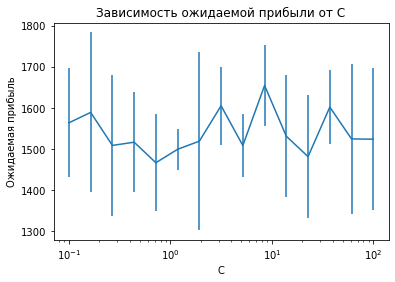

In [57]:
plt.errorbar(diap, mean_revs, yerr=std_revs)
plt.xscale('log')
plt.title('Зависимость ожидаемой прибыли от С')
plt.xlabel('C')
plt.ylabel('Ожидаемая прибыль')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [58]:
best_cs = []
for i in range(10):
    best_rev = 0
    best_c = 0
    mean_revs = []
    std_revs = []
    diap = np.logspace(-1, 2, 15)

    for C in tqdm(diap):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
        skf.get_n_splits(X_trans, y)

        revenues = []

        for train_index, test_index in skf.split(X_trans, y):
            X_train, X_test = X_trans[train_index], X_trans[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = LR(C = C)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            income = np.random.uniform(low=0, high=20, size=((pred > 0) & (y_test > 0)).sum())
            revenues.append(income.sum() - (pred > 0).sum())
        revenues = np.array(revenues)
        mean_revs.append(revenues.mean())
        std_revs.append(revenues.std())
        if revenues.mean() > best_rev:
            best_rev = revenues.mean()
            best_c = C
    best_cs.append(best_c)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.47s/it]


In [59]:
best_cs

[100.0,
 0.16378937069540642,
 0.16378937069540642,
 3.1622776601683795,
 3.1622776601683795,
 8.483428982440717,
 8.483428982440717,
 8.483428982440717,
 37.27593720314938,
 13.894954943731374]

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Кажется, что recall, потому что нам важно не потерять людей, которые готовы будут оформить вклад.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [61]:
best_rev = 0
best_tr = 0
mean_revs = []
std_revs = []
diap = np.arange(0, 1, 0.01)

for tr in tqdm(diap):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
    skf.get_n_splits(X_trans, y)

    revenues = []

    for train_index, test_index in skf.split(X_trans, y):
        X_train, X_test = X_trans[train_index], X_trans[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LR(C = 37)
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[:,1]
        income = np.random.uniform(low=0, high=20, size=((pred > tr) & (y_test > 0)).sum())
        revenues.append(income.sum() - (pred > tr).sum())
    revenues = np.array(revenues)
    mean_revs.append(revenues.mean())
    std_revs.append(revenues.std())
    if revenues.mean() > best_rev:
        best_rev = revenues.mean()
        best_tr = tr
best_tr

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


0.13

Порог довольно маленький, т.е. я был прав.

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Да, заметил, что лучший порог всегда где то между 0.1 и 0.2, это и логично, потому что в этом случае recall меньше, а он нам важнее.

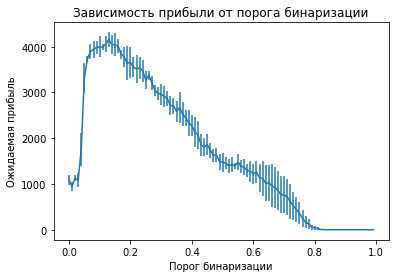

In [62]:
plt.errorbar(diap, mean_revs, yerr=std_revs)
plt.title('Зависимость прибыли от порога бинаризации')
plt.xlabel('Порог бинаризации')
plt.ylabel('Ожидаемая прибыль')
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [624]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [651]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
skf.get_n_splits(X_trans, y)

precs = []
recs = []

for train_index, test_index in skf.split(X_trans, y):
    X_train, X_test = X_trans[train_index], X_trans[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LR(C=37)
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    pred = pred > 0.14
    precs.append(precision_score(y_test, pred))
    recs.append(recall_score(y_test, pred))
    

In [652]:
precs = np.array(precs)
recs = np.array(recs)
print(precs)
print(recs)

[0.35741445 0.32519864 0.3485342  0.33351987 0.26190476]
[0.60775862 0.6174569  0.57650862 0.64224138 0.7112069 ]


In [653]:
print(f'Mean precision: {precs.mean()}')
print(f'Mean recall: {recs.mean()}')

Mean precision: 0.3253143832273047
Mean recall: 0.6310344827586206


In [654]:
print(f'Std precision: {precs.std()}')
print(f'Std recall: {recs.std()}')

Std precision: 0.03363836380948111
Std recall: 0.045282218806848934


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [838]:
recalls = []
precs = []

for tr in tqdm(diap):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
    skf.get_n_splits(X_trans, y)

    mean_rec = 0
    mean_prec = 0
    for train_index, test_index in skf.split(X_trans, y):
        X_train, X_test = X_trans[train_index], X_trans[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LR(C = 37)
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[:,1]
        mean_rec += recall_score(y_test, pred > tr) / 5
        mean_prec += precision_score(y_test, pred > tr) / 5
    
    recalls.append(mean_rec)
    precs.append(mean_prec)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


In [839]:
recalls = np.array(recalls)
precs = np.array(precs)

In [842]:
mask = recalls > 0.5

recalls = recalls[mask]
precs = precs[mask]

recalls = (recalls - recalls.min()) / (recalls.max() - recalls.min())
precs = (precs - precs.min()) / (precs.max() - precs.min())
print('PR AUC: ', auc(recalls, precs))

PR AUC:  0.3897400894891916
